# Wstęp
Narzędziem wykorzystywanym w projekcie jest język Python wraz ze swoją biblioteką `pandas`, przeznaczoną do analizy danych. Niniejszy raport przygotowano w środowisku `jupyter`, które udostępnia przeglądarkowy interfejs z jądrem obliczeniowym Pythona. Można tam w łatwy sposób wykonywać kod i od razu uzyskiwać wyniki czy wykresy, a także przeplatać komórki kodu z komórkami tekstu formatowanymi zgodnie z językiem `markdown`, co nadaje całemu dokumentowi przystępną w odbiorze formę.

Do testów statystycznych wykorzystano funkcje z biblioteki `SciPy`, do analizy post-hoc użyto pakietu `scikit-posthocs`,  do analizy przeżycia zastosowano pakiet `lifelines`, regresja logistyczna pochodzi ze `statsmodels` oraz `sklearn` (podobnie jak inne funkcje wykorzystywane w zadaniu klasyfikacji).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon, bartlett, ttest_ind, mannwhitneyu, f_oneway, friedmanchisquare
plt.rcParams['figure.figsize'] = [10, 5]

Do typowej dla biblioteki `pandas` struktury danych `DataFrame` wczytano pierwszy zbiór danych analizowany w projekcie, tj. *crime.csv*. Został on pobrany spośród wielu zbiorów danych udostępnionych przez Uniwersytet Sheffield pod [tym](https://www.sheffield.ac.uk/mash/statistics/datasets) adresem . Następnie sprawdzono, czy gdziekolwiek w zbiorze występują puste wartości wymagające uzupełnienia -- nie stwierdzono takiego przypadku.

In [2]:
df = pd.read_csv('crime.csv')
print(df.isnull().values.any(), df.isna().values.any())

False False


Dane opisują przestępczość w Stanach Zjednoczonych, tj. dla każdego stanu dysponujemy próbką zawierającą wartość współczynnika przestępczości w tym stanie i szereg dodatkowych czynników. Dane zebrano w pewnym punkcie czasu, a także 10 lat później, co uwzględniono w nazwach kolumn struktury `DataFrame` (liczba 10 na końcu oznacza, że dane w tej kolumnie są późniejsze). Obserwacje przechowywane są albo jako liczby całkowite, albo zmiennoprzecinkowe.

In [3]:
print(df.dtypes)

CrimeRate              float64
Youth                    int64
Southern                 int64
Education              float64
ExpenditureYear0         int64
LabourForce              int64
Males                    int64
MoreMales                int64
StateSize                int64
YouthUnemployment        int64
MatureUnemployment       int64
HighYouthUnemploy        int64
Wage                     int64
BelowWage                int64
CrimeRate10            float64
Youth10                  int64
Education10            float64
ExpenditureYear10        int64
LabourForce10            int64
Males10                  int64
MoreMales10              int64
StateSize10              int64
YouthUnemploy10          int64
MatureUnemploy10         int64
HighYouthUnemploy10      int64
Wage10                   int64
BelowWage10              int64
dtype: object


W poniższej tabeli przedstawiono opisy zmiennych (kolumn) występujących w zbiorze danych. Dla kategorycznych cech binarych wartości liczbowe $0$, $1$ zastąpiono odpowiednio słowami **nie**, **tak** dla łatwiejszej interpretacji.


| Cecha                 | Opis                                                                                                                                      | Rodzaj zmiennej |
|-----------------------|-------------------------------------------------------------------------------------------------------------------------------------------|-----------------|
| CrimeRate             | współczynnik przestępczosci (liczba wykroczeń rocznie na sto tysięcy mieszkańców)                                                                      | ciągła          |
| Youth                 | liczba mężczyzn w wieku 18-24 na 1000 mężczyzn                                                                                         | dyskretna       |
| Southern              | stan południowy (1 = tak, 0 = nie)                                                                                                        | binarna         |
| Education             | średnia liczba lat edukacji mieszkańca do osiągnięcia 25 roku życia | ciągła
| ExpenditureY.      | roczne wydatki na policję w dolarach w przeliczeniu na osobę                                                                                            | ciągła          |
| LabourForce           | liczba zatrudnionych mężczyzn w wieku 18-24 na 1000 mężczyzn w wieku 18-24                                                                           | dyskretna       |
| Males                 | liczba mężczyzn przypadających na 1000 kobiet                                                                                             | dyskretna       |
| MoreMales             | więcej mężczyzn przypada na 1000 kobiet (1 = tak, 0 = nie)                                                                                | binarna         |
| StateSize             | liczba ludności stanu (w setkach tysięcy mieszkańców)                                                                                             | dyskretna       |
| YouthUn.     | liczba niezatrudnionych młodych mężczyzn w wieku 18-24 na 1000 mężczyzn w wieku 18-24                                                                        | dyskretna       |
| MatureUn.    | liczba niezatrudnionych dojrzałych mężczyzn w wieku 35-39 na 1000 mężczyzn w wieku 35-39                                                                        | dyskretna       |
| HighYouthUn. | wysokie bezrobocie młodych mężczyzn w stosunku do dojrzałych (1 = tak, 0 = nie, tak, gdy Youth > 3 * Mature) | binarna         |
| Wage                  | mediana tygodniowej pensji w dolarach                                                                                                               | ciągła          |
| BelowWage             | liczba rodzin żyjących za kwotę poniżej połowy przeciętnej tygodniowej pensji na 1000 rodzin                                                                               | dyskretna       |

In [4]:
df = df.replace({'Southern' : {0 : 'nie', 1 : 'tak'}, 'MoreMales' : {0 : 'nie', 1 : 'tak'},
                 'HighYouthUnemploy' : {0 : 'nie', 1 : 'tak'}, 'MoreMales10' : {0 : 'nie', 1 : 'tak'},
                 'HighYouthUnemploy10' : {0 : 'nie', 1 : 'tak'}})

Dla wygody dane zapisano w osobnych strukturach danych: pierwsza (`df1`) odnosi się do danych pozyskanych wcześniej, a druga (`df2`) -- po 10 latach. Jedynym parametrem niezmiennym na przestrzeni lat jest *Southern*, tj. przynależność stanu do stanów południowych lub nie.

Poniżej pokazano początkową część zawartości tabel.

In [5]:
df1 = df.loc[:, 'CrimeRate' : 'BelowWage']
df1.head()

,CrimeRate,Youth,Southern,Education,ExpenditureYear0,LabourForce,Males,MoreMales,StateSize,YouthUnemployment,MatureUnemployment,HighYouthUnemploy,Wage,BelowWage
0,45.5,135,nie,12.4,69,540,965,nie,6,80,22,tak,564,139
1,52.3,140,nie,10.9,55,535,1045,tak,6,135,40,tak,453,200
2,56.6,157,tak,11.2,47,512,962,nie,22,97,34,nie,288,276
3,60.3,139,tak,11.9,46,480,968,nie,19,135,53,nie,457,249
4,64.2,126,nie,12.2,106,599,989,nie,40,78,25,tak,593,171


In [6]:
df2 = df.loc[:, 'CrimeRate10' : ]
southern = df['Southern']
df2.insert(2, 'Southern', southern)
df2.head()

,CrimeRate10,Youth10,Southern,Education10,ExpenditureYear10,LabourForce10,Males10,MoreMales10,StateSize10,YouthUnemploy10,MatureUnemploy10,HighYouthUnemploy10,Wage10,BelowWage10
0,26.5,135,nie,12.5,71,564,974,nie,6,82,20,tak,632,142
1,35.9,135,nie,10.9,54,540,1039,tak,7,138,39,tak,521,210
2,37.1,153,tak,11.0,44,529,959,nie,24,98,33,nie,359,256
3,42.7,139,tak,11.8,41,497,983,nie,20,131,50,nie,510,235
4,46.7,125,nie,12.2,97,602,989,nie,42,79,24,tak,660,162


# Statystyka opisowa

Biblioteka `pandas` umożliwia wykonanie dla struktury `DataFrame` statystyki opisowej poprzez pojedyncze wywołanie metody `describe()`. Domyślnie podaje ona dla każdej z cech:

- liczność obserwacji,
- wartość średnią,
- odchylenie standardowe,
- wartość minmalną,
- wartość pierwszego kwartylu,
- wartość drugiego kwartylu (medianę),
- wartość trzeciego kwartylu,
- wartość maksymalną.

Domyślna implementacja została uzupełniona o wartości rozstępu, dominanty (mody), wariancji, współczynnika zmienności, skośności oraz kurtozy.

In [7]:
stats = df1.describe()
stats.loc['rozstęp'] = stats.loc['max'] - stats.loc['min']
stats.loc['moda'] = df1.mode().iloc[0]
stats.loc['wariancja'] = df1.var(numeric_only=True).tolist()
stats.loc['wsp. zm.'] = stats.loc['std'] / stats.loc['mean']
stats.loc['skośność'] = df1.skew(numeric_only=True).tolist()
stats.loc['kurtoza'] = df1.kurtosis(numeric_only=True).tolist()
stats = stats.rename(index={'count' : 'liczność', 'mean' : 'średnia', 'std' : 'odch. st.', 'min' : 'w. min.', 
                    '25%' : '1 kwartyl', '50%' : 'mediana', '75%' : '3 kwartyl', 'max' : 'w. maks.'})
stats

,CrimeRate,Youth,Education,ExpenditureYear0,LabourForce,Males,StateSize,YouthUnemployment,MatureUnemployment,Wage,BelowWage
liczność,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
średnia,102.808511,138.574468,12.391489,85.000000,561.191489,983.021277,36.617021,95.468085,33.978723,525.382979,194.000000
odch. st.,28.893266,12.567634,1.120332,29.718974,40.411814,29.467365,38.071188,18.028783,8.445450,96.490944,39.896061
w. min.,45.500000,119.000000,10.000000,45.000000,480.000000,934.000000,3.000000,70.000000,20.000000,288.000000,126.000000
1 kwartyl,82.700000,130.000000,11.550000,62.500000,530.500000,964.500000,10.000000,80.500000,27.500000,459.500000,165.500000
mediana,103.000000,136.000000,12.400000,78.000000,560.000000,977.000000,25.000000,92.000000,34.000000,537.000000,176.000000
3 kwartyl,120.650000,146.000000,13.200000,104.500000,593.000000,992.000000,41.500000,104.000000,38.500000,591.500000,227.500000
w. maks.,161.800000,177.000000,15.100000,166.000000,641.000000,1071.000000,168.000000,142.000000,58.000000,689.000000,276.000000
rozstęp,116.300000,58.000000,5.100000,121.000000,161.000000,137.000000,165.000000,72.000000,38.000000,401.000000,150.000000
moda,45.500000,126.000000,12.900000,58.000000,521.000000,964.000000,7.000000,102.000000,35.000000,557.000000,166.000000


#### Przykładowe odczytane informacje
1. średnio wśród $1000$ mężczyzn jest ok. $139$ mężczyzn w wieku 18-24,
2. mediana wydatków *per capita* na policję to $78$ dolarów rocznie,
3. maksymalna liczba pracujących mężczyzn w wieku 18-24 na $1000$ mężczyzn w wieku 18-24 w pojedynczym stanie to $641$,
4. rozstęp mediany pensji wynosi $401$ dolarów,
5. minimalna wartość stopy bezrobocia wśród mężczyzn w wieku 18-24 to $\frac{70}{1000}=7\%$, a w wieku 35-39 jest to $\frac{20}{1000}=2\%$,
6. współczynnik zmienności w liczbie ludności stanów jest zbliżony do $1$, co oznacza, że odchylenie standardowe i średnia są dla tej cechy niemal jednakowe.

Liczba ludności stanu (*StateSize*) charakteryzuje się dodatnią skośnością równą $1.98$. Świadczy to o prawostronnej asymetrii rozkładu wartości cechy, co można zobaczyć na poniższym histogramie. Wartość średnia tej cechy jest większa niż jej mediana.

Podobnie dodatnia kurtoza równa $3.87$ informuje o smukłym (*leptokurtycznym*) rozkładzie, tj. większym skupieniu obserwacji wokół średniej ($36.6$). Potwierdza to rozkład empiryczny prezentowany na histogramie, gdzie dwa prostokąty są wyraźnie wyższe od czterech pozostałych.

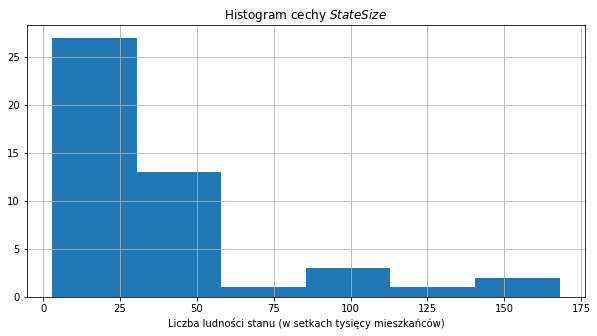

In [8]:
hist = df1.hist(column='StateSize', bins=6)
plt.title("Histogram cechy $\it{StateSize}$")
plt.xlabel("Liczba ludności stanu (w setkach tysięcy mieszkańców)")
plt.show()

## Wykres pudełkowy

Wygodnym narzędziem graficznej interpretacji danych statystycznych jest wykres pudełkowy, na którym dla wybranej cechy oznaczone są wartości pierwszego kwartylu ($Q1$), mediany oraz trzeciego kwartylu ($Q3$) (tworzące *pudełko*), a *wąsy* mają maksymalną długość półtora rozstępu międzykwartylowego: $IQR=1.5\cdot(Q3-Q1)$. Na wykresach tego typu można porównać parametry statystyczne cechy pomiędzy różnymi grupami obserwacji, np. w stanach południowych i niepołudniowych.

#### Porównanie poziomu bezrobocia wśród młodych i  współczynnika przestępczości w zależności od położenia stanu na południu lub nie

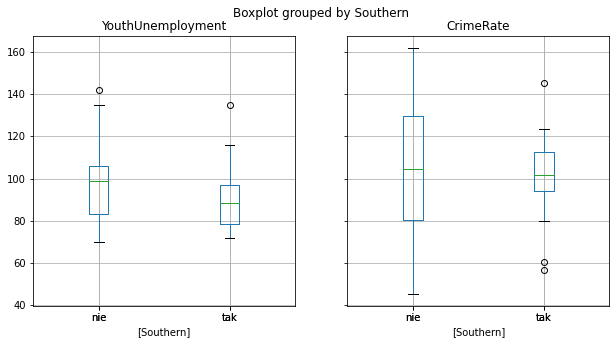

In [9]:
boxpl1 = df1.boxplot(column=['YouthUnemployment', 'CrimeRate'], by=['Southern'])

Parametry bezrobocia wśród młodych są do siebie zbliżone w obu rodzajach stanów. Natomiast współczynnik przestępczości ma ponaddwukrotnie mniejszy rozstęp międzykwartylowy w stanach południowych, co świadczy o większej koncentracji obserwacji.

#### Porównanie wartości współczynnika przestępczości w zależności od przewagi liczebnej mężczyzn w stanie

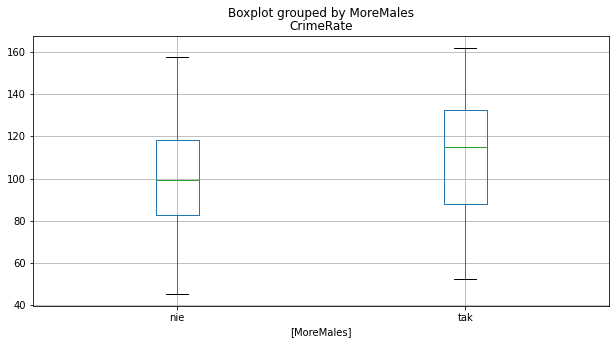

In [10]:
boxpl12 = df1.boxplot(column=['CrimeRate'], by=['MoreMales'])

Różnice we współczynniku przestępczości nie są znaczne, wartości maksymalne i minimalne są bardzo zbliżone, natomiast w stanach, w których mieszka więcej mężczyzn niż kobiet, mamy większą medianę i trzeci kwartyl współczynnika.

#### Porównanie liczby ludności  w stanach z wysokim i niskim wskaźnikiem bezrobocia wśród młodych mężczyzn w stosunku do dojrzałych mężczyzn

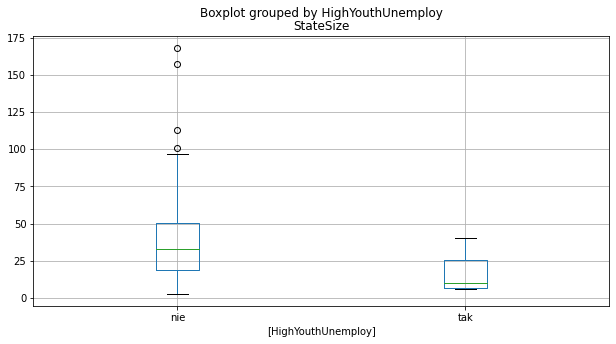

In [11]:
boxpl3 = df1.boxplot(column=['StateSize'], by=['HighYouthUnemploy'])

Stany z niskim wskaźnikiem bezrobocia młodzi/dojrzali mają zróżnicowaną liczbę ludności -- w $75\%$ poniżej 5 milionów, natomiast zdarzają się wartości odstające sięgające powyżej 15 milionów. Stany z wysokim wskaźnikiem bezrobocia młodzi/dojrzali są stosunkowo małe -- w $75\%$ poniżej $2.5$ miliona mieszkańców.

# Testy parametryczne

## Test t-Studenta dla danych zależnych

Porównana zostanie wartość współczynnika przestępczości w roku 0 (kiedy pierwszy raz przeprowadzono badania) i po 10 latach w różnych stanach USA. Są to dane zależne, ponieważ opisują ten sam parametr dla tej samej grupy stanów, ale w innym czasie. Liczność każdej z grup próbek wynosi $47$, więc przekracza wymaganą dla testu wartość ok. 20-25 obserwacji.

In [12]:
x0 = df1['CrimeRate']
x1 = df2['CrimeRate10']

Aby móc zastosować parowy test t-Studenta dla danych zależnych, należy zweryfikować założenie o normalności rozkładu różnic w grupach. Wykorzystany zostanie do tego test Shapiro-Wilka z hipotezą zerową, że dane pochodzą z rozkładu normalnego. Założony poziom istotności $\alpha = 0.05$.

In [13]:
alpha = 0.05
diff = x0 - x1
statistic, pval = shapiro(diff)
print(pval <= alpha)

False


Ponieważ p wartość testu Shapiro-Wilka jest większa niż założony poziom istotności testu, nie ma podstaw do odrzucenia hipotezy o normalnym rozkładzie różnic pomiędzy testowanymi grupami. Można zatem wykonać test t-Studenta z poziomem istotności $\alpha=0.05$.

**Hipoteza zerowa**: brak statystycznie istotnych różnic między średnimi wartościami współczynnika przestępczości w roku 0 i po 10 latach.

In [14]:
alpha = 0.05
statistic, pval = ttest_rel(x0, x1)
print(pval <= alpha)

False


Brak podstaw do odrzucenia hipotezy zerowej, zatem nie można stwierdzić, że w statystycznym sensie średni współczynnik przestępczości na przestrzeni 10 lat zmienił się.

## Test t-Studenta dla danych niezależnych

Testy danych niezależnych porównują ten sam parametr dla różnych grup. Przeanalizowana zostanie średnia liczba lat edukacji mieszkańca przed osiągnięciem 25 roku życia w stanach południowych i niepołudniowych. Na początek zbadane zostanie (testem Shapiro-Wilka z $\alpha=0.05$), czy dane w obu grupach pochodzą z rozkładu normalnego.

In [15]:
x0 = df1['Education'][df1['Southern']=='tak']
x1 = df1['Education'][df1['Southern']=='nie']
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
print(pval1 <= alpha, pval2 <= alpha)

False False


Brak podstaw do odrzucenia H0 mówiącej o normalności rozkładów x0 i x1, zatem spełnione jest pierwsze założenie testu t-Studenta dla danych niezależnych. W drugim kroku zostanie zbadana równość wariancji w obu grupach. Wykorzystany zostanie tutaj test Bartletta o poziomie istotności $\alpha=0.05$ z H0, że obie próbki pochodzą z populacji o równych wariancjach.

In [16]:
statistic, pval = bartlett(x0, x1)
print(pval <= alpha)

False


Brak podstaw do odrzucenia hipotezy zerowej -- spełnione drugie założenie t-testu dla danych niezależnych. Można zatem wykonać test t-Studenta z poziomem istotności $\alpha=0.05$.

**Hipoteza zerowa**: brak statystycznie istotnych różnic między średnią liczbą lat edukacji do 25 roku życia w stanach południowych i niepołudniowych.

In [17]:
statistic, pval = ttest_ind(x0, x1)
print(pval <= alpha)

True


Wobec p wartości mniejszej od zadanego progu istotności należy przyjąć hipotezę alternatywną: istnieje statystycznie istotna różnica w średniej liczbie lat edukacji pomiędzy stanami południowymi a pozostałymi.

In [18]:
print("W stanach południowych młodzież średnio uczy się {mean0:.1f} lat, a w pozostałych stanach {mean1:.1f} i jest to statystycznie istotna różnica.".format(mean0 = x0.mean(), mean1 = x1.mean()))

W stanach południowych młodzież średnio uczy się 11.6 lat, a w pozostałych stanach 12.8 i jest to statystycznie istotna różnica.


## ANOVA

ANOVA jest testem parametrycznym, który (wykorzystując analizę wariancji) pozwala porównać średnie w wielu niezależnych grupach obserwacji. Reprezentowane w danych stany USA uszeregowano względem liczby ludności i podzielono na trzy części: stany małe (15 stanów), średnie (15 stanów) i duże (17 stanów). Na tej podstawie utworzono trzy niezależne od siebie grupy obserwacji: liczba pracujących młodych mężczyzn w wieku 18-24 (na 1000 młodych mężczyzn) w stanach małych, w stanach średnich, w stanach dużych.

Kolejno zbadano założenia testu parametrycznego ANOVA:

1. normalność rozkładu w każdej z grup,
2. równość wariancji pomiędzy grupami.

Do zbadania pierwszej hipotezy zerowej posłużył test Shapiro-Wilka z poziomem istotności $\alpha=0.05$, natomiast do określenia prawdziwości hipotezy zerowej mówiącej o równości wariancji wykorzystano test Bartletta, również z $\alpha=0.05$. Wyniki nie dają podstaw do odrzucenia żadnej z hipotez, ponieważ otrzymane p wartości są zbyt duże. Płynącym z tego wnioskiem jest, że można wykonać test ANOVA, jako że jego założenia są spełnione.

In [19]:
orderedStateSizes = df1['StateSize'].sort_values()
smallStateInd = orderedStateSizes[:15].index
mediumStateInd = orderedStateSizes[15:30].index
largeStateInd = orderedStateSizes[30:47].index
x0 = df1['LabourForce'][smallStateInd]
x1 = df1['LabourForce'][mediumStateInd]
x2 = df1['LabourForce'][largeStateInd]
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
statistic3, pval3 = shapiro(x2)
print(pval1 <= alpha, pval2 <= alpha, pval3 <= alpha)
statistic4, pval4 = bartlett(x0, x1, x2)
print(pval4 <= alpha)

False False False
False


**Hipoteza zerowa**: średnio tyle samo młodych mężczyzn pracuje w stanach małych, w stanach średnich, a także w stanach dużych.

In [20]:
alpha = 0.05
statistic, pval = f_oneway(x0, x1, x2)
print(pval <= alpha)
print("W stanach małych pracuje średnio {mean0:.0f} młodych mężczyzn na 1000 młodych mężczyzn, w stanach średnich - {mean1:.0f}, a w stanach dużych - {mean2:.0f}. Brak statystycznie istotnej różnicy między tymi wartościami.".format(mean0 = x0.mean(), mean1 = x1.mean(), mean2 = x2.mean()))

False
W stanach małych pracuje średnio 576 młodych mężczyzn na 1000 młodych mężczyzn, w stanach średnich - 551, a w stanach dużych - 557. Brak statystycznie istotnej różnicy między tymi wartościami.


Przy przyjętym poziomie istotnośći $\alpha=0.05$ brak podstaw do odrzucenia hipotezy zerowej o równości średnich w trzech grupach.

# Testy nieparametryczne

## Test Wilcoxona

Test Wilcoxona jest alternatywą dla parowego testu t-Studenta dla danych zależnych, kiedy różnice pomiędzy dwiema grupami nie mają rozkładu normalnego. Rozważmy dwie grupy: liczbę rodzin żyjących w ubóstwie (za kwotę poniżej połowy przeciętnego tygodniowego wynagrodzenia; na 1000 rodzin) w różnych stanach USA w roku 0 i 10 lat później. Test Shapiro-Wilka na poziomie istotności $\alpha=0.05$ pozwala odrzucić hipotezę zerową o normalności rozkładu różnic w grupach.  

In [21]:
x0 = df1['BelowWage']
x1 = df2['BelowWage10']
alpha = 0.05
diff = x0 - x1
statistic, pval = shapiro(diff)
print(pval <= alpha)

True


**Hipoteza zerowa**: mediana różnicy w liczbie rodzin żyjących w ubóstwie w roku 0 i po 10 latach jest równa 0.

In [22]:
alpha = 0.05
statistic, pval = wilcoxon(x0, x1)
print(pval <= alpha)

False


Otrzymana p wartość nie jest mniejsza lub równa od zadanego poziomu istotności, zatem nie można odrzucić hipotezy zerowej. H0 w teście Wilcoxona można interpretować jako przypuszczenie o jednakowym rozkładzie badanej cechy w zależnych grupach, co znajduje potwierdzenie w histogramach.

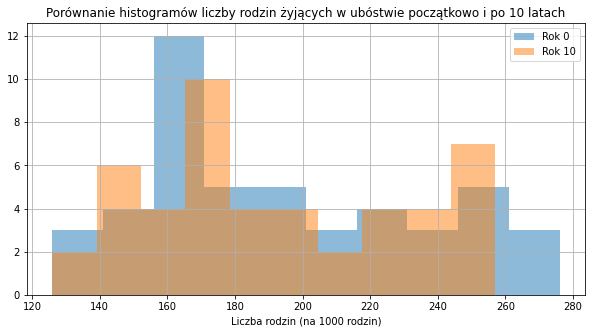

In [23]:
x0.hist(alpha=0.5)
x1.hist(alpha=0.5)
plt.title("Porównanie histogramów liczby rodzin żyjących w ubóstwie początkowo i po 10 latach")
plt.xlabel("Liczba rodzin (na 1000 rodzin)")
plt.legend(["Rok 0", "Rok 10"])
plt.show()

## Test Manna-Whitneya

Test Manna-Whitneya jest nieparametryczną wersją testu t-Studenta dla danych niezależnych. Nie wymaga on założenia o normalności rozkładu wśród grup. Do testu wybrane zostały próbki reprezentujące liczbę mieszkańców żyjących w ubóstwie w zależności od położenia stanu: południowego lub nie, są one wzajemnie niezależne. Test Shapiro-Wilka pozwoli określić, czy rozkłady w grupach można uznać za normalne.

In [24]:
x0 = df1['BelowWage'][df1['Southern']=='tak']
x1 = df1['BelowWage'][df1['Southern']=='nie']
alpha = 0.05
statistic1, pval1 = shapiro(x0)
statistic2, pval2 = shapiro(x1)
print(pval1 <= alpha, pval2 <= alpha)

True False


W grupie stanów południowych odrzucono hipotezę zerową o normalności rozkładu cechy *BelowWage*, zatem test Manna-Whitneya jest dobrym wyborem do badania statystycznego ($\alpha=0.05$).

**Hipoteza zerowa**: rozkład liczby osób w ubóstwie jest taki sam wśród stanów południowych i wśród stanów niepołudniowych.

In [25]:
alpha = 0.05
statistic, pval = mannwhitneyu(x0, x1)
print(pval <= alpha)

True


Dzięki odpowiednio małej wartości p hipoteza zerowa została odrzucona na rzecz hipotezy alternatywnej: rozkład cechy *BelowWage* jest inny dla stanów południowych, a inny dla stanów nieleżących na południu. Werdykt testu można potwierdzić, rysując odpowiednie histogramy.

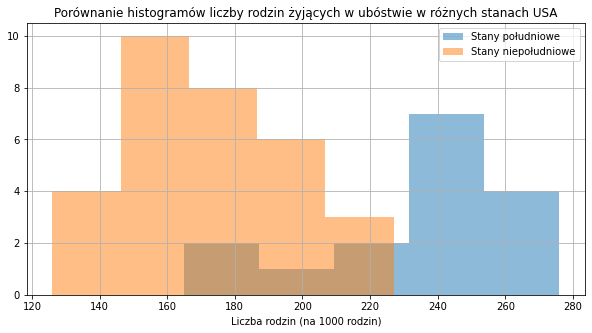

In [26]:
h1 = x0.hist(bins=5, alpha=0.5)
h2 = x1.hist(bins=5, alpha=0.5)
plt.title("Porównanie histogramów liczby rodzin żyjących w ubóstwie w różnych stanach USA")
plt.xlabel("Liczba rodzin (na 1000 rodzin)")
plt.legend(["Stany południowe", "Stany niepołudniowe"])
plt.show()

# Test rang Friedmana

Do testu rang Friedmana został wykorzystany zbiór danych *Video_R.csv*, również pochodzący z zastobów Uniwersytetu Sheffield (do pobrania [tutaj](https://www.sheffield.ac.uk/mash/statistics/datasets)). Gromadzi on dane na temat odbioru przez pacjentów czterech różnych filmików, z których każdy w odmienny sposób informuje o stanie zdrowia pacjenta. Każdego przepytanego pacjenta poproszono między innymi, by w całkowitej skali 1-5 określił, jak dobrze zrozumiał każdy z filmów (im wyższa liczba, tym lepsze zrozumienie). Aby zweryfikować tezę, czy któreś z nagrań zostało zrozumiane lepiej niż pozostałe, można użyć testu rang Friedmana.

Początkowo zbiór danych zostaje wczytany oraz zweryfikowane zostaje, że nie ma w nim pustych wartości oraz nie-liczb.

In [27]:
import scikit_posthocs as sp
video_df = pd.read_csv("Video_R.csv")
print(video_df.isnull().values.any(), video_df.isna().values.any())
video_df.head()

False False


,Person,Gender,Heardofcondition,Set,@1st,@2nd,@3rd,@4th,Combination,VideoAGenUnderstandingCONDITION,VideoBdoctorUnderstandingCONDITION,VideoCOldUnderstandingCONDITION,DEMOUnderstandingCONDITION,TotalAGen,TotalBdoc,TotalCOld,TotalDDEMO
0,1,1,1,1,4,1,3,2,4132,5,5,3,5,25,23,13,22
1,2,2,1,1,4,1,3,2,4132,5,5,5,5,23,23,20,22
2,3,2,2,1,4,1,3,2,4132,4,4,2,5,20,17,14,23
3,4,2,0,1,4,1,3,2,4132,5,5,5,5,24,24,23,25
4,5,2,2,1,4,1,3,2,4132,5,5,4,5,25,22,18,23


Do testu Friedmana użyte zostaną wartości z czterech kolumn zbioru danych, zawierające kolejne noty wystawiane filmom przez pacjentów. Są to dane zależne (głosowała za każdym razem ta sama próba pacjentów, oceny zrozumiałości filmów są w takiej samej skali), zatem spełnione jest założenie testu, nie ma natomiast konieczności, by weryfikować normalność rozkładu. Każdy ciąg ocen składa się z 20 elementów, a założony poziom istotności testu $\alpha=0.05$.

**Hipoteza zerowa**: średnie zrozumienie jest takie samo dla każdego filmu.

In [28]:
vid1 = video_df["VideoAGenUnderstandingCONDITION"]
vid2 = video_df["VideoBdoctorUnderstandingCONDITION"]
vid3 = video_df["VideoCOldUnderstandingCONDITION"]
vid4 = video_df["DEMOUnderstandingCONDITION"]

alpha = 0.05
statistic, pval = friedmanchisquare(vid1, vid2, vid3, vid4)
print(pval <= alpha)

True


Na podstawie p-wartości **hipoteza zerowa zostaje odrzucona** na rzecz alternatywnej: filmy nie zostały średnio jednakowo dobrze zrozumiane. Można zatem przeprowadzić analizę post-hoc, by znaleźć pary filmów statystycznie różniące się w ocenach.

Jako że żadne z nagrań nie jest jakkolwiek wyróżnione wśród pozostałych, do analizy wybrano test Nemenyi. Biblioteczna implementacja zwraca symetryczną macierz o wymiarach 4x4, w komórkach której znajdują się p-wartości testu. Odpowiednio mała wartość (< $\alpha$) świadczy o istnieniu statystycznie istotnej różnicy między porównywanymi filmami.

In [29]:
results = sp.posthoc_nemenyi([vid1, vid2, vid3, vid4])
results

,1,2,3,4
1,1.000000,0.848853,0.000372,0.887936
2,0.848853,1.000000,0.009405,0.412209
3,0.000372,0.009405,1.000000,0.000010
4,0.887936,0.412209,0.000010,1.000000


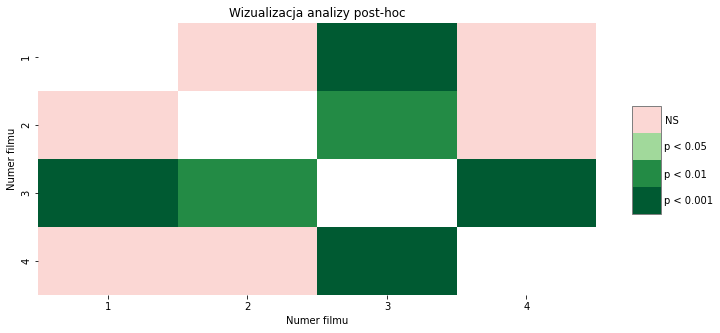

Średnia vid1: 4.75, średnia vid2: 4.55, średnia vid3: 3.3, średnia vid4: 4.9


In [30]:
ax, cbar = sp.sign_plot(results)
ax.set_title("Wizualizacja analizy post-hoc")
ax.set_xlabel("Numer filmu")
ax.set_ylabel("Numer filmu")
plt.show()

print("Średnia vid1: {}, średnia vid2: {}, średnia vid3: {}, średnia vid4: {}"
      .format(vid1.mean(), vid2.mean(), vid3.mean(), vid4.mean()))

Analiza wykresu pozwala stwierdzić, że pomiędzy filmami 1 i 2, 1 i 4 oraz 2 i 4 nie stwierdzono statystycznie istotnej różnicy (NS - *nonsignificant*) w ocenach ich zrozumienia przez pacjentów. Natomiast p-wartości mniejsze od $0.05$, a nawet od $0.01$, wystąpiły w parach 1-3, 2-3, 3-4, co oznacza statystycznie istotną różnicę w odbiorze filmów. Kolejno średni poziom zrozumienia wyniósł: 
- $4.75$ dla filmu 1, 
- $4.55$ dla filmu 2, 
- $3.3$ dla filmu 3, 
- $4.9$ dla filmu 4.

Uzyskano zatem statystyczne potwierdzenie, że **film 3 został uznany za mniej zrozumiały niż pozostałe**.

# Krzywe przeżycia, wykres Kaplana-Meiera

Do wykreślenia krzywych przeżycia postanowiono zbadać dane udostępnione na [stronie](https://dmkd.cs.vt.edu/projects/survival/data/) Uniwersytetu Stanowego Virginii, a zebrane z portalu [Kickstarter](https://www.kickstarter.com/). Jest to platforma do organizacji publicznych zbiórek wspierających biznesowe przedsięwzięcia o różnej skali -- organizator wyznacza finansowy cel i jeśli otrzyma pierwotnie założone finansowe wsparcie, rozpoczyna realizację przedsięwzięcia.

W zbiorze danych zawarto informacje o 5229 projektach, dla których określono, w ile dni po starcie zbiórki projekt osiągnął sukces, zbierając wymaganą kwotę. Wśród 56 cech opisujących każdy projekt jest między innymi zmienna logiczna, która mówi, czy projekt był promowany w formie wideo, czy nie.

Dla obu tych kategorii można wykreślić krzywe przeżycia, czyli funkcje prognozujące prawdopodobieństwo, że po upływie danej liczby dni projekt nie zbierze jeszcze pełnej kwoty. Użytym estymatorem funkcji przeżycia jest estymator Kaplana-Meiera.

**Hipoteza zerowa**: szansa, że nie uda się przeprowadzić udanej zbiórki do 30 dnia jest taka sama dla projektów promowanych przez wideo i niepromowanych przez wideo.

In [31]:
kick_df = pd.read_csv("kickstarter_2.csv")
print(video_df.isnull().values.any(), video_df.isna().values.any())
kick_df.shape
kick_df.head()

False False


,day_succ,Status,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,usr_net_bic,1f_plg,1f_bck,1prj_prom,2f_plg,2f_bck,2prj_prom,3f_plg,3f_bck,3prj_prom
0,60,0,0,0,0,0,0,0,0,0,...,0.000000,-0.313453,-0.179145,0.000000,-0.319593,-0.172518,0.000000,-0.324429,-0.173517,0.000000
1,19,0,0,0,0,0,0,0,0,0,...,0.470316,-0.313453,-0.179145,-0.265049,-0.319593,-0.172518,-0.280888,-0.324429,-0.173517,-0.258752
2,11,1,0,1,0,0,0,0,0,0,...,0.000000,0.145388,-0.172303,0.000000,0.096156,-0.167501,0.000000,0.034410,-0.169265,0.000000
3,32,1,0,0,0,0,0,1,0,0,...,0.835936,0.079839,0.183493,-0.265049,0.058360,0.143569,-0.280888,0.034410,0.128363,-0.258752
4,28,1,0,0,0,0,0,0,0,0,...,-0.260923,-0.198743,-0.110723,-0.265049,-0.206207,-0.117328,-0.280888,-0.193942,-0.096984,-0.258752


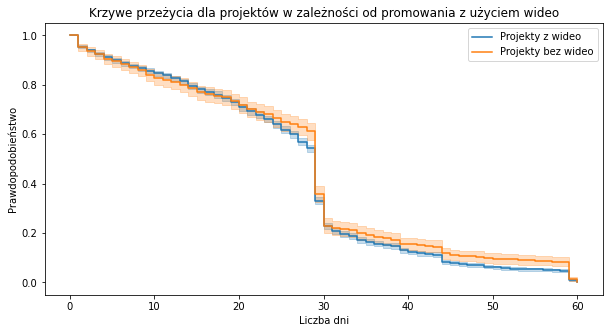

In [32]:
from lifelines import KaplanMeierFitter

has_video = kick_df["has_video"] == 1
days_video = kick_df["day_succ"][has_video]
days_no_video = kick_df["day_succ"][~has_video]

kmf_vid = KaplanMeierFitter().fit(days_video, label="Projekty z wideo")
kmf_vid.plot_survival_function()

kmf_no_vid = KaplanMeierFitter().fit(days_no_video, label="Projekty bez wideo")
kmf_no_vid.plot_survival_function()

plt.title("Krzywe przeżycia dla projektów w zależności od promowania z użyciem wideo")
plt.xlabel("Liczba dni")
plt.ylabel("Prawdopodobieństwo")
plt.show()

Na wykresie wyraźnie widać, że krzywe mają zbliżony przebieg. Prawdopodobieństwo, że projekt nie zbierze funduszy do dnia *d* po starcie maleje w podobny sposób niezależnie od użycia wideo - ok. 30 dnia szansa na brak sukcesu przedsięwzięcia wynosi mniej więcej $0.35$, natomiast przy 40 dniu już tylko ok. 10% projektów wciąż pozostaje bez zebranej pełnej kwoty. Najpóźniej udaje się to w okolicach 60 dnia po rozpoczęciu zbiórki.

Do weryfikacji hipotezy zerowej posłuży specjalny biblioteczny test `survival_difference_at_fixed_point_in_time_test`, wykorzystujący transformację *log(-log)*. Otrzymana p-wartość znacznie przekracza poziom istotności $0.05$, czyli **hipoteza zerowa może zostać podtrzymana**.

In [33]:
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test 

alpha = 0.05
day_number = 30
result = survival_difference_at_fixed_point_in_time_test(day_number, kmf_vid, kmf_no_vid)
print(result.p_value, result.p_value <= alpha)

0.8805820523896237 False


# Regresja logistyczna

Do wykonania regresji logistycznej i wizualizacji jakości klasyfikacji krzywą ROC wykorzystany zostanie zbiór danych z [KEEL](https://sci2s.ugr.es/keel/dataset.php?cod=21). Zgromadzone zostały tam dane 768 kobiet z plemienia Indian Pima -- 8 niezależnych cech oraz binarna wartość określająca, czy dana osoba jest chora na cukrzycę (1 -- chora, 0 -- zdrowa).

Regresja logistyczna jest statystycznym modelem, który wykorzystuje tzw. funkcję logistyczną i dopasowuje ją na podstawie $n$ zmiennych niezależnych (predyktorów) do binarnej zmiennej zależnej. Na podstawie danych uczących metodą największej wiarygodności estymowane są parametry $\beta_i$ występujące w funkcji logistycznej, zwracającej dla wektora wejściowego $X$ prawdopodobieństwo, że należy on do klasy 1:
$$ \theta = (\beta_1, \dots, \beta_n)^T $$
$$ p(Y=1 | X) = \frac{1}{1 + e^{\beta_0 + \beta^TX}}$$

Biblioteczna klasa `Logit` przeprowadza dopasowanie do danych i zwraca wyniki, w tym uzyskane współczynniki $\beta$ oraz dla każdej zmiennej niezależnej wartość statystyki $Z$, która weryfikuje **hipotezę zerową**, że stowarzyszony z tą zmienną współczynnik $\beta$ jest równy 0, a tym samym zmienna statystycznie nieistotna.

In [34]:
pima_df = pd.read_csv("pima.csv")
pima_df.rename(columns={"Class" : "HasDiabetes"}, inplace=True)
isIll = pima_df["HasDiabetes"] == "tested_positive"
pima_df.loc[isIll, "HasDiabetes"] = 1
pima_df.loc[~isIll, "HasDiabetes"] = 0
pima_df.head()

,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,HasDiabetes
0,14,175,62,30,0,33.6,0.212,38,1
1,4,146,78,0,0,38.5,0.520,67,1
2,15,136,70,32,110,37.1,0.153,43,1
3,3,107,62,13,48,22.9,0.678,23,1
4,3,169,74,19,125,29.9,0.268,31,1


In [35]:
import statsmodels.api as sm
X = pima_df.iloc[:, :-1].to_numpy()
y = pima_df.iloc[:, -1].to_numpy().astype('int')
X_c = sm.add_constant(X)

model = sm.Logit(y, X_c)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Sun, 09 Jan 2022   Pseudo R-squ.:                  0.2718
Time:                        01:13:06   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.4047      0.717    -11.728      0.000      -9.809      -7.000
x1             0.1232      0.

Na podstawie p-wartości z tabeli przekraczających $\alpha=0.05$ odrzucone zostają trzy cechy: czwarta, piąta i ósma.

Zamodelowana na przekształconym zbiorze danych regresja logistyczna może służyć do klasyfikacji obserwacji. Ze względu na łatwiejsze API wykorzystana zostanie wersja z pakietu `sklearn`.

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

pima = pd.read_csv("pima.csv")
pima.rename(columns={"Class" : "HasDiabetes"}, inplace=True)
isIll = pima["HasDiabetes"] == "tested_positive"
pima.loc[isIll, "HasDiabetes"] = 1
pima.loc[~isIll, "HasDiabetes"] = 0
pima.drop(columns=pima_df.columns[[3, 4, 7]], inplace=True) # eliminiacja słabo dyskryminujących cech
pima.head()

X = pima.iloc[:, :-1].to_numpy()
y = pima.iloc[:, -1].to_numpy().astype('int')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=444)
clf = LogisticRegression(random_state=444).fit(X_train, y_train)
y_pos_class_probab_LR = clf.predict_proba(X_test)[:, 1] # przewidywane prawdopodobieństwa dla klasy 1
y_pred = clf.predict(X_test) # przewidywane klasy na zbiorze testowym
print(accuracy_score(y_test, y_pred))

0.78125


Uzyskana dokładność klasyfikacji na zbiorze testowym przy pojedynczym podziale na zbiór treningowy i testowy wyniosła $0.78$.

# Wizualizacja jakości klasyfikacji (ROC)

Do dokładniejszego określenia jakości klasyfikacji z poprzedniego punktu może posłużyć macierz konfuzji, która w zadaniu klasyfikacji binarnej składa się z czterech liczb:
- wartości TN (*true negative*), czyli liczby poprawnie sklasyfikowanych przypadków negatywnych (rzeczywista klasa 0),
- wartości FP (*false positive*), czyli liczby błędnie sklasyfikowanych przypadków negatywnych (rzeczywista klasa 0),
- wartości FN (*false negative*), czyli liczby błędnie sklasyfikowanych przypadków pozytywnych (rzeczywista klasa 1),
- wartości TP (*true positive*), czyli liczby poprawnie sklasyfikowanych przypadków pozytywnych (rzeczywista klasa 1).

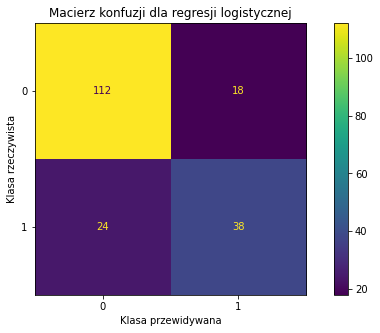

In [37]:
import sklearn.metrics as skm
cm = skm.confusion_matrix(y_test, y_pred)
disp = skm.ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Macierz konfuzji dla regresji logistycznej")
plt.ylabel("Klasa rzeczywista")
plt.xlabel("Klasa przewidywana")
plt.show()

Na podstawie macierzy konfuzji można wyznaczyć szereg parametrów charakteryzujących klasyfikację, są to m. in.:
$$\text{precyzja} =\frac{TP}{TP + FP} = 0.68$$

$$\text{czułość} \, (\textit{recall})=\frac{TP}{TP + FN} = 0.61$$

$$\text{specyficzność}=\frac{TN}{TN + FP}=0.86$$

$$\text{f1-score}=\frac{2 \cdot \text{precyzja} \cdot \text{specyficzność}}{ \text{precyzja} + \text{specyficzność} } = 0.64$$

In [38]:
print("Precyzja: {:.2f}, czułość: {:.2f}, specyficzność: {:.2f}, f1-score: {:.2f}"
      .format(skm.precision_score(y_test, y_pred), skm.recall_score(y_test, y_pred), 
             cm[0, 0] / (cm[0, 0] + cm[0, 1]), skm.f1_score(y_test, y_pred)))

Precyzja: 0.68, czułość: 0.61, specyficzność: 0.86, f1-score: 0.64


Przeprowadzona klasyfikacja chorych na cukrzycę wykazała się dość dużą specyficznością, co oznacza, ze klasyfikator ze sporą dokładnością określa brak choroby u badanego.

Jakość klasyfikacji można pokazać w inny sposób -- wykreślając krzywą ROC. Na podstawie faktycznych etykiet z testowego zbioru danych oraz przewidywanych przez logistyczną regresję prawdopodobieństw wspierających klasę pozytywną powstaje wykres, w którym na osi X mamy

$$FPR = 1-\text{specyficzność},$$ 
a na osi Y 

$$TPR = \text{czułość}$$

Krzywa ROC powstaje z punktów o współrzędnych $(FPR, TPR)$ wyliczanych w zależności od przyjętego progu, tj. wartości prawdopodobieństwa rozdzielającej obszary decyzyjne klas 0 i 1.

[0. 1.]


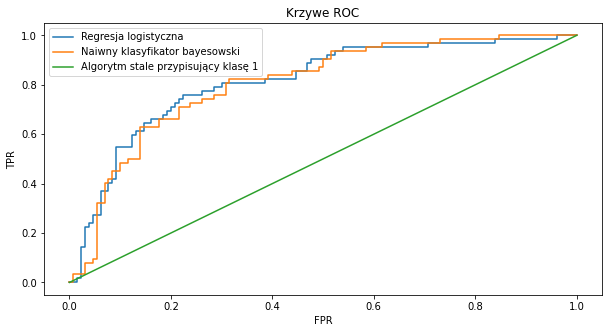

In [39]:
from sklearn.naive_bayes import GaussianNB
y_pos_class_probab_GNB = GaussianNB().fit(X_train, y_train).predict_proba(X_test)[:, 1] # naiwny Bayes

y_const_probab = np.ones_like(y_test) # przewiduje pozytywną klasę z prawdopodobieństwem 1

fprLR, tprLR, _ = skm.roc_curve(y_test, y_pos_class_probab_LR)
fprGNB, tprGNB, _ = skm.roc_curve(y_test, y_pos_class_probab_GNB)
fpr_const, tpr_const, _ = skm.roc_curve(y_test, y_const_probab)
print(tpr_const)
plt.plot(fprLR, tprLR, label="Regresja logistyczna")
plt.plot(fprGNB, tprGNB, label="Naiwny klasyfikator bayesowski")
plt.plot(fpr_const, tpr_const, label="Algorytm stale przypisujący klasę 1")
plt.legend()
plt.title("Krzywe ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

Na wykresie przedstawiono krzywą ROC dla algorytmu regresji logistycznej, dla naiwnego klasyfikatorwa bayesowskiego oraz prymitywnego algorytmu stale przypisującego próbki do klasy 1. Punkt $(0, 1)$ oznacza idealną klasyfikację przy zerowym FPR i pełnym TPR, im bliżej tego punktu, tym lepiej. Do dokładniejszego porównania algorytmów można wykorzystać parametr AUC -- pole pod krzywą ROC, im większe, tym lepsza jakość klasyfikacji. 

In [40]:
print("Regresja logistyczna AUC: {:.3f},\n"
      "Naiwny klasyfikator bayesowski AUC: {:.3f}\n"
      "Algorytm stale przypisujący klasę 1 AUC: {:.3f}"
      .format(skm.roc_auc_score(y_test, y_pos_class_probab_LR), 
             skm.roc_auc_score(y_test, y_pos_class_probab_GNB), 
             skm.roc_auc_score(y_test, y_const_probab)))

Regresja logistyczna AUC: 0.813,
Naiwny klasyfikator bayesowski AUC: 0.805
Algorytm stale przypisujący klasę 1 AUC: 0.500


Regresja logistyczna i naiwny klasyfikator bayesowski wypadły niemal identycznie: AUC $0.813$ kontra $0.805$. Natomiast algorytm stale przypisujacy klasę 1 ma niezmiennie $(FPR, TPR) = (1, 1)$ i tym samym AUC dokładnie $0.5$. 